In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#hide
from fastbook import *

# CNN Interpretation with CAM

Now that we know how to build up pretty much anything from scratch, let's use that knowledge to create entirely new (and very useful!) functionality: the *class activation map*. It gives us some insight into why a CNN made the predictions it did.

In the process, we'll learn about one handy feature of PyTorch we haven't seen before, the *hook*, and we'll apply many of the concepts introduced in the rest of the book. If you want to really test out your understanding of the material in this book, after you've finished this chapter, try putting it aside and recreating the ideas here yourself from scratch (no peeking!).

## CAM and Hooks

The class activation map (CAM) was introduced by Bolei Zhou et al. in ["Learning Deep Features for Discriminative Localization"](https://arxiv.org/abs/1512.04150). It uses the output of the last convolutional layer (just before the average pooling layer) together with the predictions to give us a heatmap visualization of why the model made its decision. This is a useful tool for interpretation.

More precisely, at each position of our final convolutional layer, we have as many filters as in the last linear layer. We can therefore compute the dot product of those activations with the final weights to get, for each location on our feature map, the score of the feature that was used to make a decision.

We're going to need a way to get access to the activations inside the model while it's training. In PyTorch this can be done with a *hook*. Hooks are PyTorch's equivalent of fastai's callbacks. However, rather than allowing you to inject code into the training loop like a fastai `Learner` callback, hooks allow you to inject code into the forward and backward calculations themselves. We can attach a hook to any layer of the model, and it will be executed when we compute the outputs (forward hook) or during backpropagation (backward hook). A forward hook is a function that takes three things—a module, its input, and its output—and it can perform any behavior you want. (fastai also provides a handy `HookCallback` that we won't cover here, but take a look at the fastai docs; it makes working with hooks a little easier.)

To illustrate, we'll use the same cats and dogs model we trained in <<chapter_intro>>:

In [28]:
path = untar_data(URLs.PETS)/'images'
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224), num_workers=0)
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.157452,0.013164,0.004060,01:32


epoch,train_loss,valid_loss,error_rate,time
0,0.073510,0.017354,0.006089,01:45


To start, we'll grab a cat picture and a batch of data:

In [65]:
print(learn.model)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Abyssinian_100.jpg		   keeshond_186.jpg
Abyssinian_100.mat		   keeshond_187.jpg
Abyssinian_101.jpg		   keeshond_188.jpg
Abyssinian_101.mat		   keeshond_189.jpg
Abyssinian_102.jpg		   keeshond_18.jpg
Abyssinian_102.mat		   keeshond_190.jpg
Abyssinian_103.jpg		   keeshond_191.jpg
Abyssinian_104.jpg		   keeshond_192.jpg
Abyssinian_105.jpg		   keeshond_193.jpg
Abyssinian_106.jpg		   keeshond_194.jpg
Abyssinian_107.jpg		   keeshond_195.jpg
Abyssinian_108.jpg		   keeshond_196.jpg
Abyssinian_109.jpg		   keeshond_197.jpg
Abyssinian_10.jpg		   keeshond_198.jpg
Abyssinian_110.jpg		   keeshond_199.jpg
Abyssinian_111.jpg		   keeshond_19.jpg
Abyssinian_112.jpg		   keeshond_1.jpg
Abyssinian_113.jpg		   keeshond_200.jpg
Abyssinian_114.jpg		   keeshond_20.jpg
Abyssinian_115.jpg		   keeshond_21.jpg
Abyssinian_116.jpg		   keeshond_22.jpg
Abyssinian_117.jpg		   keeshond_23.jpg
Abyssinian_118.jpg		   keeshond_24.jpg
Abyssinian_119.jpg		   keeshond_25.jpg
Abyssinian_11.jpg		   keeshond_26.jpg
Abyssinian_12

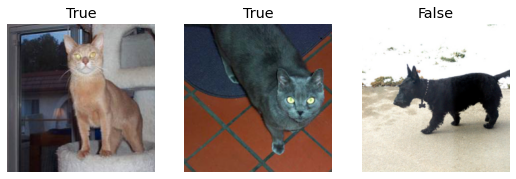

In [33]:
dls.show_batch(nrows=1, ncols=3)
!ls $path



In [49]:
# img = PILImage.create(image_cat())
test_items = [str(path)+'/Sphynx_206.jpg'] 
# , str(path)+'/great_pyrenees_1.jpg']
# plt.imshow(img)

x, = first(dls.test_dl(test_items))
# test_dl = dls.test_dl([img])
# test_batch = first(iter(test_dl))

For CAM we want to store the activations of the last convolutional layer. We put our hook function in a class so it has a state that we can access later, and just store a copy of the output:

In [50]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

We can then instantiate a `Hook` and attach it to the layer we want, which is the last layer of the CNN body:

In [51]:
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

Now we can grab a batch and feed it through our model:

In [54]:
with torch.no_grad(): output = learn.model.eval()(x)
print(output)

TensorBase([[-5.4053,  5.2636]], device='cuda:0')


And we can access our stored activations:

In [55]:
act = hook_output.stored[0]

Let's also double-check our predictions:

In [56]:
F.softmax(output, dim=-1)

TensorBase([[2.3256e-05, 9.9998e-01]], device='cuda:0')

We know `0` (for `False`) is "dog," because the classes are automatically sorted in fastai, bu we can still double-check by looking at `dls.vocab`: 

In [57]:
dls.vocab

[False, True]

So, our model is very confident this was a picture of a cat.

To do the dot product of our weight matrix (2 by number of activations) with the activations (batch size by activations by rows by cols), we use a custom `einsum`:

In [93]:
x.shape

torch.Size([1, 3, 224, 224])

In [94]:
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

RuntimeError: ignored

TypeError: ignored

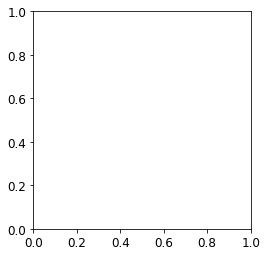

In [92]:
plt.imshow(cam_map[0].detach().cpu()) # class 0

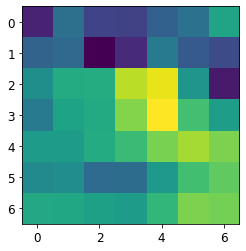

In [61]:
plt.imshow(cam_map[1].detach().cpu()) # class 1

For each image in our batch, and for each class, we get a 7×7 feature map that tells us where the activations were higher and where they were lower. This will let us see which areas of the pictures influenced the model's decision.

For instance, we can find out which areas made the model decide this animal was a cat (note that we need to `decode` the input `x` since it's been normalized by the `DataLoader`, and we need to cast to `TensorImage` since at the time this book is written PyTorch does not maintain types when indexing—this may be fixed by the time you are reading this):

TypeError: ignored

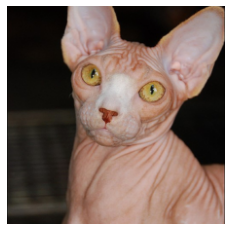

In [91]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

The areas in bright yellow correspond to high activations and the areas in purple to low activations. In this case, we can see the head and the front paw were the two main areas that made the model decide it was a picture of a cat.

Once you're done with your hook, you should remove it as otherwise it might leak some memory:

In [66]:
hook.remove()

That's why it's usually a good idea to have the `Hook` class be a *context manager*, registering the hook when you enter it and removing it when you exit. A context manager is a Python construct that calls `__enter__` when the object is created in a `with` clause, and `__exit__` at the end of the `with` clause. For instance, this is how Python handles the `with open(...) as f:` construct that you'll often see for opening files without requiring an explicit `close(f)` at the end. If we define `Hook` as follows:

In [67]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

we can safely use it this way:

In [68]:
with Hook(learn.model[0]) as hook:
    with torch.no_grad(): output = learn.model.eval()(x.cuda())
    act = hook.stored

fastai provides this `Hook` class for you, as well as some other handy classes to make working with hooks easier.

This method is useful, but only works for the last layer. *Gradient CAM* is a variant that addresses this problem.

## Gradient CAM

The method we just saw only lets us compute a heatmap with the last activations, since once we have our features, we have to multiply them by the last weight matrix. This won't work for inner layers in the network. A variant introduced in the paper ["Grad-CAM: Why Did You Say That? Visual Explanations from Deep Networks via Gradient-based Localization"](https://arxiv.org/abs/1611.07450) in 2016 uses the gradients of the final activation for the desired class. If you remember a little bit about the backward pass, the gradients of the output of the last layer with respect to the input of that layer are equal to the layer weights, since it is a linear layer.

With deeper layers, we still want the gradients, but they won't just be equal to the weights anymore. We have to calculate them. The gradients of every layer are calculated for us by PyTorch during the backward pass, but they're not stored (except for tensors where `requires_grad` is `True`). We can, however, register a hook on the backward pass, which PyTorch will give the gradients to as a parameter, so we can store them there. For this we will use a `HookBwd` class that works like `Hook`, but intercepts and stores gradients instead of activations:

In [69]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

Then for the class index `1` (for `True`, which is "cat") we intercept the features of the last convolutional layer as before, and compute the gradients of the output activations of our class. We can't just call `output.backward()`, because gradients only make sense with respect to a scalar (which is normally our loss) and `output` is a rank-2 tensor. But if we pick a single image (we'll use `0`) and a single class (we'll use `1`), then we *can* calculate the gradients of any weight or activation we like, with respect to that single value, using `output[0,cls].backward()`. Our hook intercepts the gradients that we'll use as weights:

In [85]:
cls = 1
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

The weights for our Grad-CAM are given by the average of our gradients across the feature map. Then it's exactly the same as before:

In [86]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

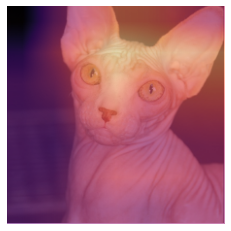

In [87]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

The novelty with Grad-CAM is that we can use it on any layer. For example, here we use it on the output of the second-to-last ResNet group:

In [88]:
with HookBwd(learn.model[0][-2]) as hookg:
    with Hook(learn.model[0][-2]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [89]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

And we can now view the activation map for this layer:

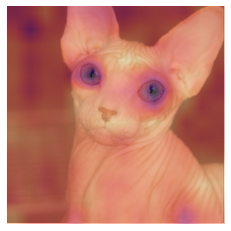

In [90]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

## Conclusion

Model interpretation is an area of active research, and we just scraped the surface of what is possible in this brief chapter. Class activation maps give us insight into why a model predicted a certain result by showing the areas of the images that were most responsible for a given prediction. This can help us analyze false positives and figure out what kind of data is missing in our training to avoid them.

## Questionnaire

1. What is a "hook" in PyTorch?
1. Which layer does CAM use the outputs of?
1. Why does CAM require a hook?
1. Look at the source code of the `ActivationStats` class and see how it uses hooks.
1. Write a hook that stores the activations of a given layer in a model (without peeking, if possible).
1. Why do we call `eval` before getting the activations? Why do we use `no_grad`?
1. Use `torch.einsum` to compute the "dog" or "cat" score of each of the locations in the last activation of the body of the model.
1. How do you check which order the categories are in (i.e., the correspondence of index->category)?
1. Why are we using `decode` when displaying the input image?
1. What is a "context manager"? What special methods need to be defined to create one?
1. Why can't we use plain CAM for the inner layers of a network?
1. Why do we need to register a hook on the backward pass in order to do Grad-CAM?
1. Why can't we call `output.backward()` when `output` is a rank-2 tensor of output activations per image per class?

### Further Research

1. Try removing `keepdim` and see what happens. Look up this parameter in the PyTorch docs. Why do we need it in this notebook?
1. Create a notebook like this one, but for NLP, and use it to find which words in a movie review are most significant in assessing the sentiment of a particular movie review.